In [1]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [2]:
import numpy as np
import pandas as pd
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, MaxPool1D, GlobalMaxPool1D, Flatten, Dropout, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from gans.utils import create_gan
from utils.windowing import windowing_dataframe, transform_windows_df
from utils.preprocess import filter_by_activity_index, calc_consultant
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

In [4]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'userAcceleration.c']
method ='sliding'

In [5]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [6]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [7]:
input_shape = x_train[0].shape
input_shape

(250, 3)

In [8]:
discriminator = Sequential()
discriminator.add(Conv1D(8, kernel_size=9, activation='relu', input_shape=input_shape))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, clipvalue=1.0, decay=1e-8), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 242, 8)            224       
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1937      
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [9]:
latent_dim = 128

In [10]:
generator = Sequential()
generator.add(Dense(125 * 3, kernel_initializer='he_uniform', input_shape=(latent_dim,)))
generator.add(LeakyReLU())
generator.add(Reshape((125, 3)))

generator.add(Conv1D(3, kernel_size=5, kernel_initializer='he_uniform', padding='same'))
generator.add(LeakyReLU())

#generator.add(Conv1D(3, kernel_size=5, kernel_initializer='he_uniform', padding='same'))#
#generator.add(LeakyReLU()) #

generator.add(Conv1DTranspose(3, kernel_size=4, strides=2, padding='same'))
generator.add(LeakyReLU())

#generator.add(Conv1D(3, kernel_size=5, kernel_initializer='he_uniform', padding='same'))
#generator.add(LeakyReLU()) #

#generator.add(Conv1D(3, kernel_size=5, kernel_initializer='he_uniform', padding='same'))
#generator.add(LeakyReLU()) #

generator.add(Conv1D(3, kernel_size=5, padding='same', kernel_initializer='he_uniform', activation='linear'))

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 375)               48375     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 375)               0         
_________________________________________________________________
reshape (Reshape)            (None, 125, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 3)            48        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 3)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 250, 3)            39        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 250, 3)           

In [11]:
gan = create_gan(generator_model=generator, discriminator_model=discriminator, optimizer=Adam(learning_rate=0.001, clipvalue=1.0, decay=1e-4), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 250, 3)            48510     
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2161      
Total params: 50,671
Trainable params: 48,510
Non-trainable params: 2,161
_________________________________________________________________
None


In [12]:
x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=0)

In [13]:
x_train_activity.shape

(1547, 250, 3)

In [14]:
steps = 1000
batch_size = 32

In [15]:
start = 0
random = False
for step in range(steps):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_sensor_data = generator.predict(random_latent_vectors)
    
    if random:
        index = np.random.choice(x_train_activity.shape[0], batch_size, replace=False)
        real_sensor_data = x_train_activity[index]
    else:
        stop = start + batch_size
        real_sensor_data = x_train_activity[start:stop]
        start += batch_size
    
    combined_sensor_data = np.concatenate([generated_sensor_data, real_sensor_data])
    labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])
    
    d_loss = discriminator.train_on_batch(combined_sensor_data, labels)
    
    misleading_targets = np.ones((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    if start > len(x_train_activity) - batch_size:
        start = 0
        
    if step % 100 == 0:
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)

discriminator loss: [0.7920571565628052, 0.375]
adversarial loss: 0.6012417674064636
discriminator loss: [0.5795639157295227, 0.609375]
adversarial loss: 1.0340750217437744
discriminator loss: [0.6465941667556763, 0.5]
adversarial loss: 0.8846255540847778
discriminator loss: [0.6876625418663025, 0.5]
adversarial loss: 0.7290637493133545
discriminator loss: [0.6898432374000549, 0.609375]
adversarial loss: 0.6931445598602295
discriminator loss: [0.7234607338905334, 0.0625]
adversarial loss: 0.683018147945404
discriminator loss: [0.698488175868988, 0.375]
adversarial loss: 0.6809221506118774
discriminator loss: [0.6995991468429565, 0.28125]
adversarial loss: 0.6805053949356079
discriminator loss: [0.6944296360015869, 0.46875]
adversarial loss: 0.680251955986023
discriminator loss: [0.6945985555648804, 0.484375]
adversarial loss: 0.6810493469238281


In [16]:
random_latent_vectors = np.random.normal(size=(1000, latent_dim))

generated_sensor_data = generator.predict(random_latent_vectors)

In [17]:
random_vec = np.random.normal(size=(batch_size, 250, 3))
(discriminator.predict(random_vec) > 0.5).sum() / len(random_vec)

0.0

In [18]:
(discriminator.predict(generated_sensor_data) > 0.5).sum() / len(generated_sensor_data)

1.0

In [19]:
(discriminator.predict(x_train_activity) > 0.5).sum() / len(x_train_activity)

0.8584356819650937

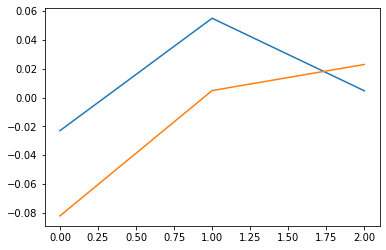

In [20]:
sns.lineplot(np.arange(len(generated_sensor_data[0][1])), generated_sensor_data[0][1])
sns.lineplot(np.arange(len(x_train_activity[0][1])), x_train_activity[0][1])

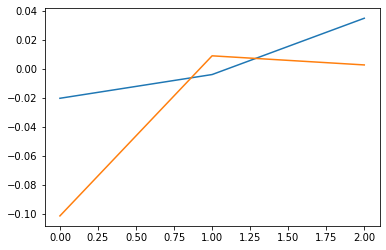

In [21]:
sns.lineplot(np.arange(len(generated_sensor_data[0][2])), generated_sensor_data[0][2])
sns.lineplot(np.arange(len(x_train_activity[0][2])), x_train_activity[0][2])

In [22]:
gen_df = pd.DataFrame(generated_sensor_data.reshape(1000, 3, 250).tolist(), columns= ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'])
gen_df['userAcceleration.c'] = calc_consultant(gen_df)
gen_df['act'] = 0

In [23]:
gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [24]:
input_cols = ['userAcceleration.c']
x_gen, y_gen = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [25]:
x_gen = x_gen.reshape((len(x_gen), window_size))

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
input_cols = ['userAcceleration.c']
x_train_clf, y_train_clf = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val_clf, y_val_clf = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test_clf, y_test_clf = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [28]:
#x_train = np.concatenate([x_train, x_val])
#y_train = np.concatenate([y_train, y_val])

In [29]:
x_train_clf = x_train_clf.reshape((len(x_train_clf), window_size))
x_val_clf = x_val_clf.reshape((len(x_val_clf), window_size))
x_test_clf = x_test_clf.reshape((len(x_test_clf), window_size))

In [30]:
svm_clf = SVC()
svm_clf.fit(x_train_clf, y_train_clf)

SVC()

In [31]:
labels=["standing", "waldking", "jogging"]

#### train performance

In [32]:
y_train_head = svm_clf.predict(x_train_clf)
# y_train_head = svm_clf.predict(x_val)

In [33]:
print(classification_report(y_train, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.60      1.00      0.75      1547
    waldking       0.87      0.42      0.57      1810
     jogging       0.99      0.83      0.90       669

    accuracy                           0.71      4026
   macro avg       0.82      0.75      0.74      4026
weighted avg       0.79      0.71      0.69      4026



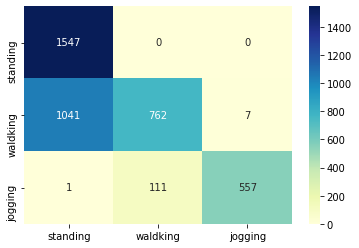

In [34]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [35]:
y_test_head = svm_clf.predict(x_test_clf)

In [36]:
print(classification_report(y_test_clf, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.68      1.00      0.81       403
    waldking       0.77      0.34      0.47       387
     jogging       0.67      0.77      0.72       173

    accuracy                           0.69       963
   macro avg       0.71      0.71      0.67       963
weighted avg       0.72      0.69      0.66       963



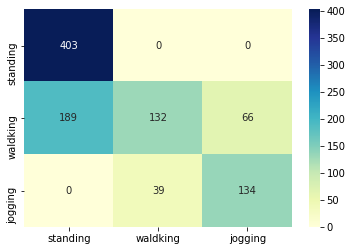

In [37]:
cm = confusion_matrix(y_test, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [38]:
# ADD 100

In [39]:
add_sample_num = 800
x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, np.zeros(add_sample_num)])

In [40]:
svm_clf = SVC()
svm_clf.fit(x_train_gen, y_train_gen)

SVC()

#### train performance

In [41]:
y_train_head = svm_clf.predict(x_train_clf)
# y_train_head = svm_clf.predict(x_val)

In [42]:
print(classification_report(y_train, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.57      1.00      0.72      1547
    waldking       0.85      0.34      0.49      1810
     jogging       0.99      0.83      0.90       669

    accuracy                           0.68      4026
   macro avg       0.80      0.72      0.70      4026
weighted avg       0.76      0.68      0.65      4026



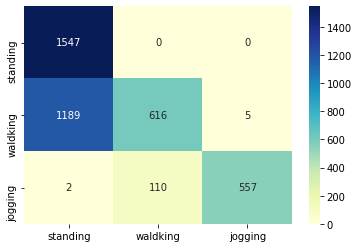

In [43]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [44]:
y_test_head = svm_clf.predict(x_test_clf)

In [45]:
print(classification_report(y_test_clf, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.66      1.00      0.79       403
    waldking       0.74      0.28      0.41       387
     jogging       0.67      0.77      0.72       173

    accuracy                           0.67       963
   macro avg       0.69      0.69      0.64       963
weighted avg       0.69      0.67      0.63       963



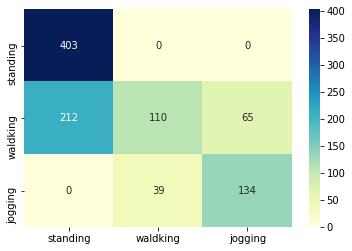

In [46]:
cm = confusion_matrix(y_test_clf, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [47]:
import os

In [50]:
def plot_n_heatmaps(x_train, generated_sensor_data, n=10, save_dir=None, file_name='plot_'):
    for i in range(n):
        plt.figure(i)
        plt.figure(figsize=(8, 20))
        fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
        sns.heatmap(x_train[i], center=0, ax=axs[0], vmin=-.20, vmax=.20)
        sns.heatmap(generated_sensor_data[i], center=0, ax=axs[1], vmin=-.20, vmax=.20)
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, file_name+i))

<ipython-input-50-f03411407c78>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=2, figsize=(10, 5))


<Figure size 432x288 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

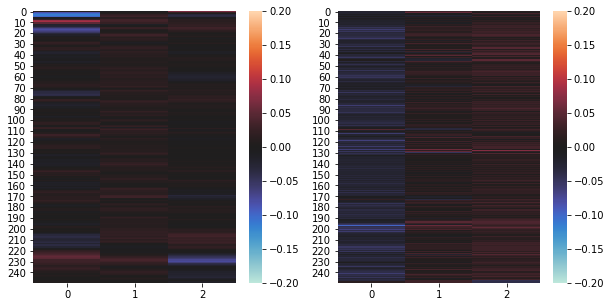

<Figure size 576x1440 with 0 Axes>

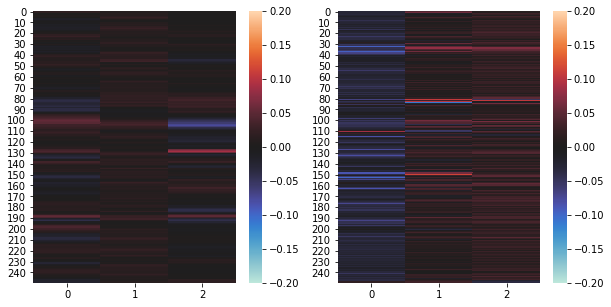

<Figure size 576x1440 with 0 Axes>

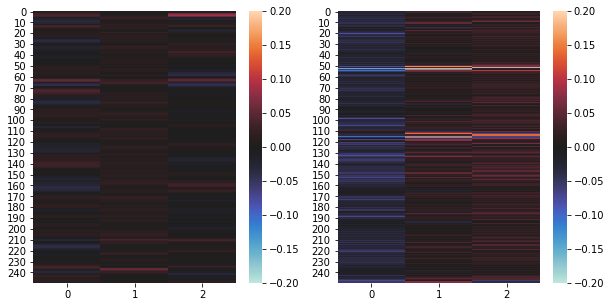

<Figure size 576x1440 with 0 Axes>

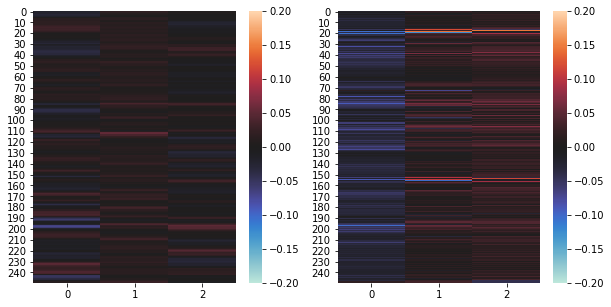

<Figure size 576x1440 with 0 Axes>

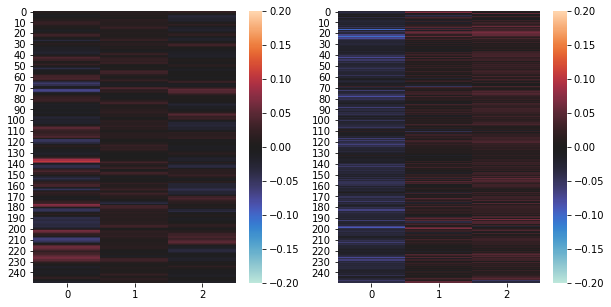

<Figure size 576x1440 with 0 Axes>

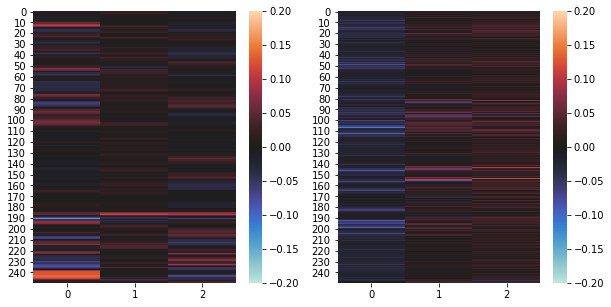

<Figure size 576x1440 with 0 Axes>

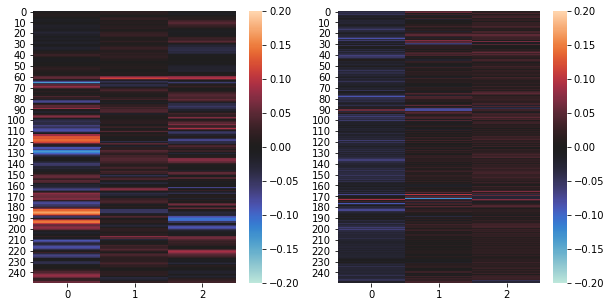

<Figure size 576x1440 with 0 Axes>

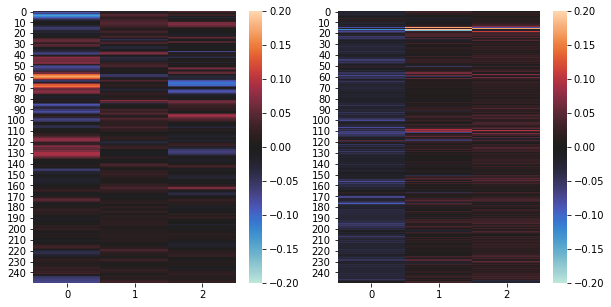

<Figure size 576x1440 with 0 Axes>

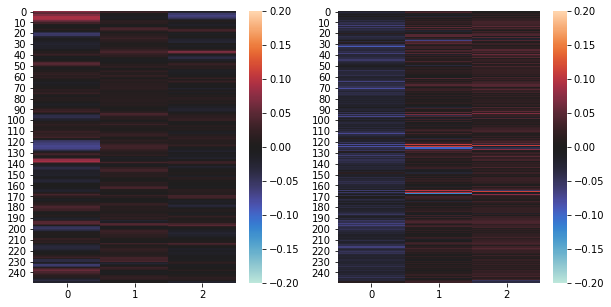

<Figure size 576x1440 with 0 Axes>

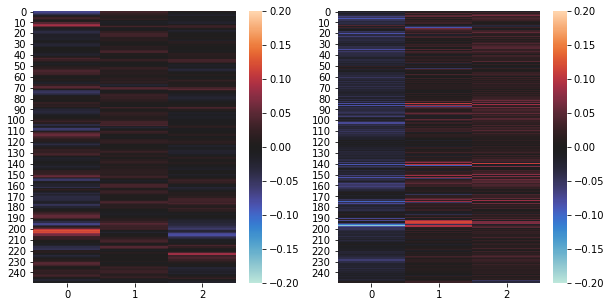

In [51]:
plot_n_heatmaps(x_train, generated_sensor_data, n=10)